In [1]:
import pandas as pd

df = pd.read_csv("Data/games.csv")
print(df.head())
print(df.info())

df = df[['BGGId','Name','GameWeight', 'AvgRating', 'NumUserRatings']].dropna()

   BGGId            Name                                        Description  \
0      1      Die Macher  die macher game seven sequential political rac...   
1      2    Dragonmaster  dragonmaster tricktaking card game base old ga...   
2      3         Samurai  samurai set medieval japan player compete gain...   
3      4  Tal der Könige  triangular box luxurious large block tal der k...   
4      5         Acquire  acquire player strategically invest business t...   

   YearPublished  GameWeight  AvgRating  BayesAvgRating   StdDev  MinPlayers  \
0           1986      4.3206    7.61428         7.10363  1.57979           3   
1           1981      1.9630    6.64537         5.78447  1.45440           3   
2           1998      2.4859    7.45601         7.23994  1.18227           2   
3           1992      2.6667    6.60006         5.67954  1.23129           2   
4           1964      2.5031    7.33861         7.14189  1.33583           2   

   MaxPlayers  ...  Rank:partygames  Rank:ch

In [2]:
#Correlation between game rating and complexity
print(df[['AvgRating','GameWeight']].corr())

            AvgRating  GameWeight
AvgRating    1.000000    0.477728
GameWeight   0.477728    1.000000


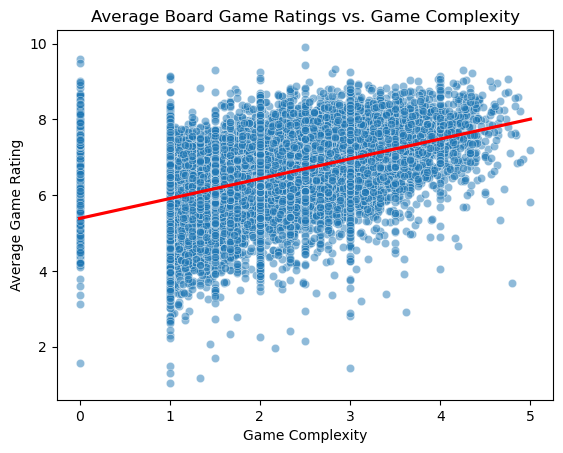

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

ax = sns.scatterplot(data=df, x='GameWeight', y='AvgRating', alpha=0.5)
sns.regplot(data=df, x='GameWeight', y='AvgRating', scatter=False, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax)

plt.title("Average Board Game Ratings vs. Game Complexity")
plt.xlabel("Game Complexity")
plt.ylabel("Average Game Rating")

plt.savefig("ratings_complexity.png")
plt.show()

In [4]:
#OLS Regression analysis of complexity vs. ratings
import statsmodels.api as sm
X= df[['GameWeight', 'NumUserRatings']]
X=sm.add_constant(X)
y=df[['AvgRating']]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              AvgRating   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     3544.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:20:27   Log-Likelihood:                -26506.
No. Observations:               21925   AIC:                         5.302e+04
Df Residuals:                   21922   BIC:                         5.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3809      0.014    386.

In [5]:
#Plotting residuals of fitted Y (game rating)
expected = model.predict(X)
y_series = y['AvgRating']

residual = y_series - expected


result_df = pd.DataFrame({
    'AvgRating': y_series,
    'GameWeight': X['GameWeight'],
    'expected_rating': expected,
    'residual': residual
})

print(result_df.info())
print(result_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21925 entries, 0 to 21924
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AvgRating        21925 non-null  float64
 1   GameWeight       21925 non-null  float64
 2   expected_rating  21925 non-null  float64
 3   residual         21925 non-null  float64
dtypes: float64(4)
memory usage: 685.3 KB
None
   AvgRating  GameWeight  expected_rating  residual
0    7.61428      4.3206         7.770139 -0.155859
1    6.64537      1.9630         6.405333  0.240037
2    7.45601      2.4859         7.149492  0.306518
3    6.60006      2.6667         6.758756 -0.158696
4    7.33861      2.5031         7.272873  0.065737


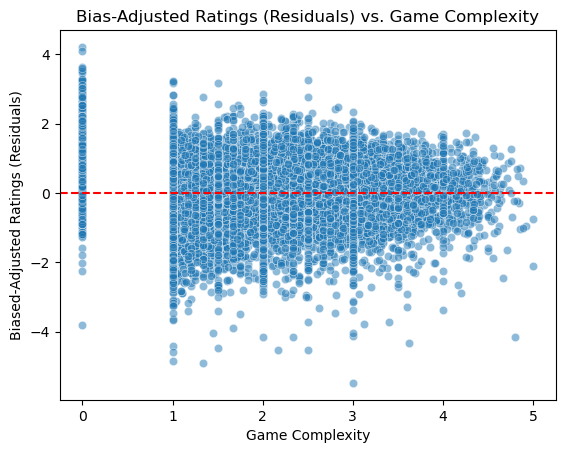

In [6]:
#Scatterplot of residuals to show that model is a good fit
sns.scatterplot(data=result_df, x='GameWeight', y='residual', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Bias-Adjusted Ratings (Residuals) vs. Game Complexity")
plt.xlabel("Game Complexity")
plt.ylabel("Biased-Adjusted Ratings (Residuals)")
plt.savefig("residuals.png")
plt.show()

df["FittedValues"] = model.fittedvalues

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Base data and category themes
df = pd.read_csv("Data/games.csv")
themes_df = pd.read_csv("Data/themes.csv")

# Model adjusting for complexity bias
X_base = df[['GameWeight', 'NumUserRatings']]
X_base = sm.add_constant(X_base)
y_base = df['AvgRating']

base_model = sm.OLS(y_base, X_base).fit()
df['FittedValues'] = base_model.fittedvalues

# Merge FittedValues into themes_df
themes_df = themes_df.merge(df[['BGGId', 'FittedValues', 'NumUserRatings']], on='BGGId', how='left')

# Drop missing fields
themes_df = themes_df.dropna(subset=['FittedValues'])

# Model: FittedValues vs. Themes
y = themes_df['FittedValues']

# Automatically pick numeric theme columns, ignoring non-theme columns
ignore_cols = ['BGGId', 'average_rating', 'AvgRating', 'FittedValues', 'NumUserRatings']
theme_cols = [col for col in themes_df.columns 
              if col not in ignore_cols and pd.api.types.is_numeric_dtype(themes_df[col])]

X = themes_df[theme_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
valid = X.notnull().all(axis=1)
X = X.loc[valid]
y = y.loc[valid]

# Add constant for intercept
X = sm.add_constant(X)

# Run regression
theme_model = sm.OLS(y, X).fit()
print(theme_model.summary())

# Sorted coefficients
coef_df = theme_model.params.drop('const').sort_values(ascending=False)
print("\nTop positive themes:\n", coef_df.head(10))
print("\nTop negative themes:\n", coef_df.tail(10))


                            OLS Regression Results                            
Dep. Variable:           FittedValues   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     54.35
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:20:31   Log-Likelihood:                -9371.6
No. Observations:               21925   AIC:                         1.918e+04
Df Residuals:                   21707   BIC:                         2.092e+04
Df Model:                         217                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

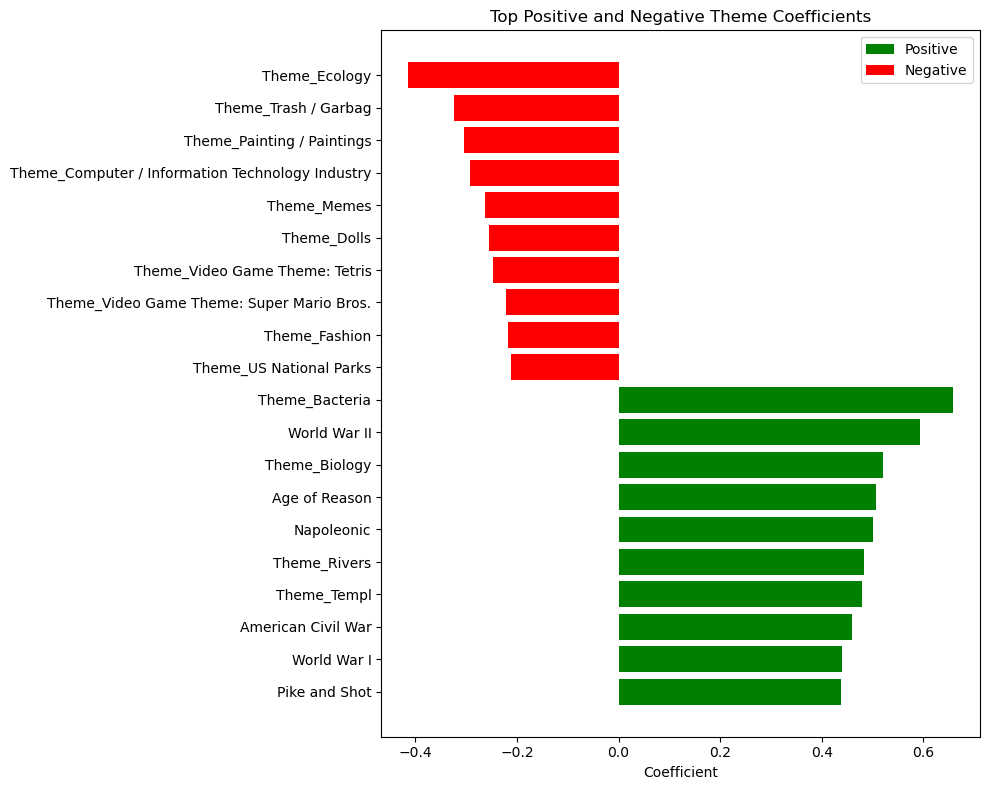

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Top 10 positive and negative coefficients
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,8))

# Plot positive coefficients (green)
plt.barh(top_pos.index[::-1], top_pos[::-1], color='green', label='Positive')

# Plot negative coefficients (red)
plt.barh(top_neg.index, top_neg, color='red', label='Negative')

plt.xlabel("Coefficient")
plt.title("Top Positive and Negative Theme Coefficients")
plt.legend()
plt.tight_layout()
plt.savefig("theme.png")
plt.show()


In [9]:
# Category: Mechanics
mechanics_df = pd.read_csv("Data/mechanics.csv")

# Merge FittedValues into mechanics_df
mechanics_df = mechanics_df.merge(df[['BGGId', 'FittedValues', 'NumUserRatings']], on='BGGId', how='left')

# Drop missing fields
mechanics_df = mechanics_df.dropna(subset=['FittedValues'])

# Model: FittedValues vs. Mechanics
y = themes_df['FittedValues']

# Automatically pick mechanics columns, ignoring columns that are not mechanics
ignore_cols = ['BGGId', 'average_rating', 'AvgRating', 'FittedValues', 'NumUserRatings']
mechanics_cols = [col for col in mechanics_df.columns 
              if col not in ignore_cols and pd.api.types.is_numeric_dtype(mechanics_df[col])]

X = mechanics_df[mechanics_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
valid = X.notnull().all(axis=1)
X = X.loc[valid]
y = y.loc[valid]

# Add constant for intercept
X = sm.add_constant(X)

# Run regression
mechanic_model = sm.OLS(y, X).fit()
print(mechanic_model.summary())
# Sorted coefficients
coef_df = mechanic_model.params.drop('const').sort_values(ascending=False)
print("\nTop positive mechanics:\n", coef_df.head(10))
print("\nTop negative mechanics:\n", coef_df.tail(10))

                            OLS Regression Results                            
Dep. Variable:           FittedValues   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:20:34   Log-Likelihood:                -7662.8
No. Observations:               21925   AIC:                         1.564e+04
Df Residuals:                   21767   BIC:                         1.690e+04
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


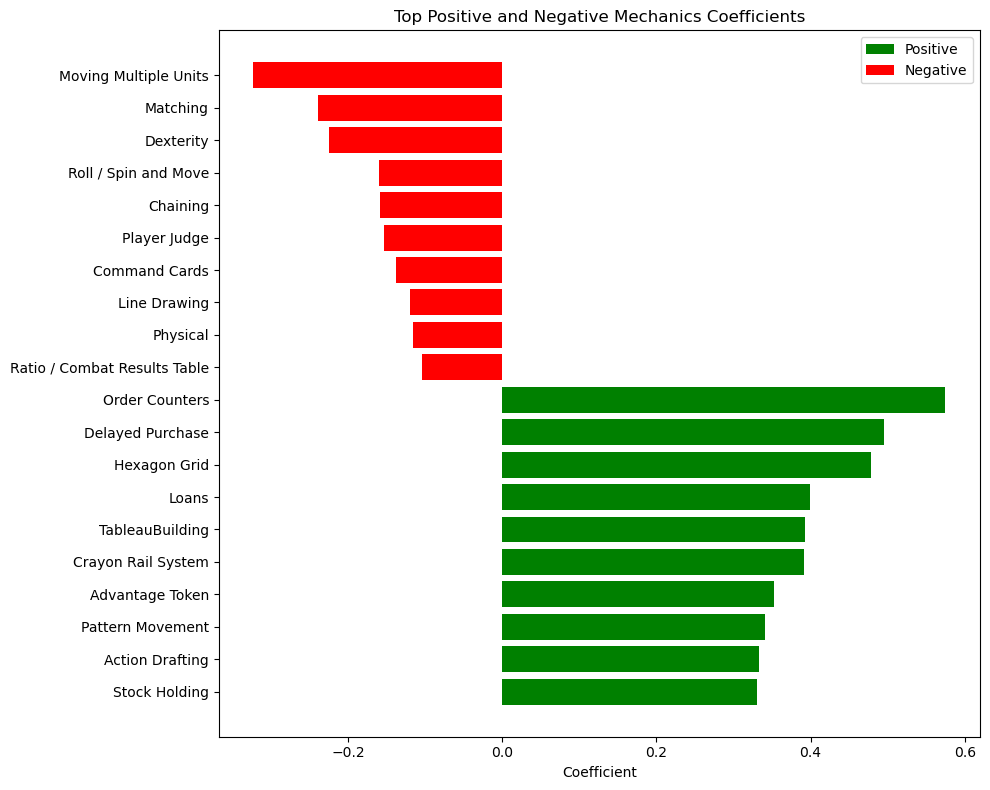

In [10]:
# Top 10 positive and negative coefficients
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,8))

# Plot positive coefficients (green)
plt.barh(top_pos.index[::-1], top_pos[::-1], color='green', label='Positive')

# Plot negative coefficients (red)
plt.barh(top_neg.index, top_neg, color='red', label='Negative')

plt.xlabel("Coefficient")
plt.title("Top Positive and Negative Mechanics Coefficients")
plt.legend()
plt.tight_layout()
plt.savefig("mechanics.png")
plt.show()

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Category: Publishers
publishers_df = pd.read_csv("Data/publishers_reduced.csv")

# Merge FittedValues into publishers_df
publishers_df = publishers_df.merge(df[['BGGId', 'FittedValues', 'NumUserRatings']], on='BGGId', how='left')

# Drop missing fields
publishers_df = publishers_df.dropna(subset=['FittedValues'])

# Model: FittedValues vs. Publishers
y = publishers_df['FittedValues']

# Automatically pick mechanics columns, ignoring columns that are not mechanics
ignore_cols = ['BGGId', 'average_rating', 'AvgRating', 'FittedValues', 'NumUserRatings']
publisher_cols = [col for col in publishers_df.columns 
              if col not in ignore_cols and pd.api.types.is_numeric_dtype(publishers_df[col])]

# Only keep publishers that appear in >= 10 games
min_games = 10
publisher_counts = publishers_df[publisher_cols].sum()
keep_cols = publisher_counts[publisher_counts >= min_games].index.tolist()

X = publishers_df[keep_cols].apply(pd.to_numeric, errors='coerce')
y = publishers_df['FittedValues']

# Drop rows with missing values
valid = X.notnull().all(axis=1)
X = X.loc[valid].astype(np.float32)
y = y.loc[valid]

# Ridge Regression (because of high number of publishers)
ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(X, y)

# In-sample R squared value
r_squared = ridge.score(X, y)
print("In-Sample R-Square: ", r_squared)

# Corss-validated R squared value
cross_validated = cross_val_score(ridge, X, y, cv=10, scoring='r2')
print("Cross-Validated R Squared Mean: ", cross_validated.mean())

#Sorted coefficients
coef_df = pd.Series(ridge.coef_, index=keep_cols).sort_values(ascending=False)

print("\nTop positive publishers:\n", coef_df.head(10))
print("\nTop negative publishers:\n", coef_df.tail(10))

In-Sample R-Square:  0.39985753635367993
Cross-Validated R Squared Mean:  0.29378017147264424

Top positive publishers:
 Games Research/Design (GR/D)    1.032366
Australian Design Group         0.946222
All-Aboard Games                0.929529
Deep Thought Games, LLC         0.875447
Clash of Arms Games             0.871980
Critical Hit, Inc.              0.814762
Against the Odds                0.714255
Dragon                          0.702306
Splotter Spellen                0.701454
Sierra Madre Games              0.696528
dtype: float32

Top negative publishers:
 Drei Magier Spiele         -0.318114
Haywire Group              -0.338960
W. Nostheide Verlag GmbH   -0.350086
Philos                     -0.351007
Djeco                      -0.352629
HABA                       -0.358583
Exploding Kittens          -0.375151
TDC Games, Inc.            -0.384881
Jax, Ltd.                  -0.413914
The Creativity Hub         -0.571779
dtype: float32


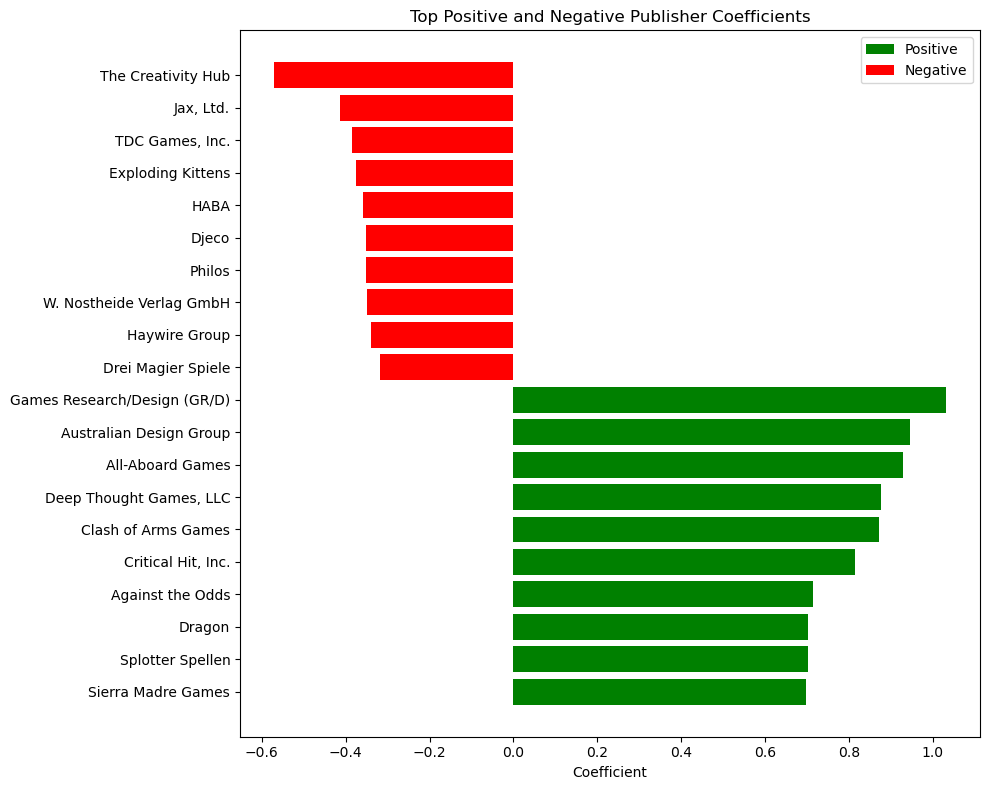

In [12]:
# Top 10 positive and negative coefficients
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,8))

# Plot positive coefficients (green)
plt.barh(top_pos.index[::-1], top_pos[::-1], color='green', label='Positive')

# Plot negative coefficients (red)
plt.barh(top_neg.index, top_neg, color='red', label='Negative')

plt.xlabel("Coefficient")
plt.title("Top Positive and Negative Publisher Coefficients")
plt.legend()
plt.tight_layout()
plt.savefig("publishers.png")
plt.show()

In [13]:
# Category: Artists
artists_df = pd.read_csv("Data/artists_reduced.csv")

# Merge FittedValues into artists_df
artists_df = artists_df.merge(df[['BGGId', 'FittedValues', 'NumUserRatings']], on='BGGId', how='left')

# Drop missing fields
artists_df = artists_df.dropna(subset=['FittedValues'])

# Model: FittedValues vs. Artists
y = artists_df['FittedValues']

# Automatically pick mechanics columns, ignoring columns that are not mechanics
ignore_cols = ['BGGId', 'average_rating', 'AvgRating', 'FittedValues', 'NumUserRatings']
artist_cols = [col for col in artists_df.columns 
              if col not in ignore_cols and pd.api.types.is_numeric_dtype(artists_df[col])]

# Only keep artists that appear in >= 10 games
min_games = 10
artist_counts = artists_df[artist_cols].sum()
keep_cols = artist_counts[artist_counts >= min_games].index.tolist()

X = artists_df[keep_cols].apply(pd.to_numeric, errors='coerce')
y = artists_df['FittedValues']

# Drop rows with missing values
valid = X.notnull().all(axis=1)
X = X.loc[valid]
y = y.loc[valid]

# Ridge Regression (because of high number of publishers)
ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(X, y)

# In-sample R squared value
r_squared = ridge.score(X, y)
print("In-Sample R-Square: ", r_squared)

# Corss-validated R squared value
cross_validated = cross_val_score(ridge, X, y, cv=10, scoring='r2')
print("Cross-Validated R Squared Mean: ", cross_validated.mean())


#Sorted coefficients
coef_df = pd.Series(ridge.coef_, index=keep_cols).sort_values(ascending=False)

print("\nTop positive artists:\n", coef_df.head(10))
print("\nTop negative artists:\n", coef_df.tail(10))

In-Sample R-Square:  0.22552472559093417
Cross-Validated R Squared Mean:  0.16856770296324255

Top positive artists:
 Milan Vavroň         0.911852
Mariano Iannelli     0.736797
Phil Eklund          0.734531
Antonio Pinar        0.698928
Zbigniew Kasprzak    0.685964
Steve Venters        0.651892
Timothy Schleif      0.632306
Rick Barber          0.577091
David Pentland       0.564364
Mike Doyle (I)       0.562515
dtype: float64

Top negative artists:
 Stéphane Escapa    -0.323755
Kaja Foglio        -0.325786
Aza Chen           -0.341630
Stivo              -0.362104
Thies Schwarz      -0.374645
Manu Palau         -0.383790
Ulrike Fischer     -0.390769
Bernhard Skopnik   -0.399955
Felicia Cano       -0.411002
Rory O'Connor      -0.564734
dtype: float64


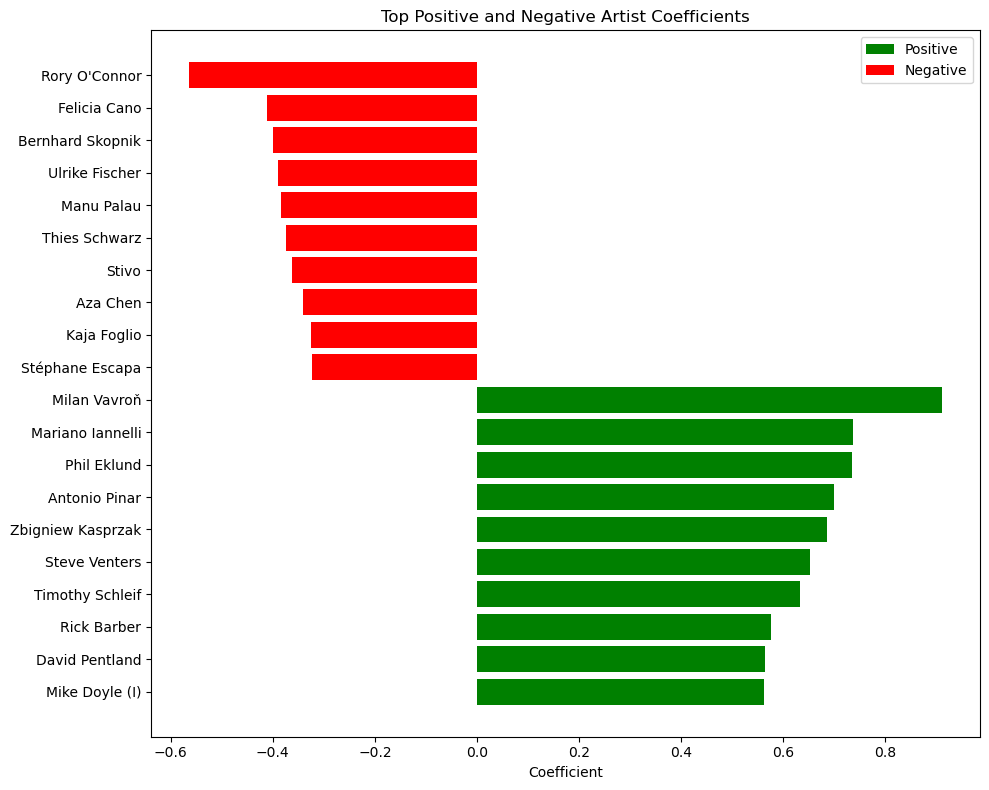

In [14]:
# Top 10 positive and negative coefficients
top_pos = coef_df.head(10)
top_neg = coef_df.tail(10)

plt.figure(figsize=(10,8))

# Plot positive coefficients (green)
plt.barh(top_pos.index[::-1], top_pos[::-1], color='green', label='Positive')

# Plot negative coefficients (red)
plt.barh(top_neg.index, top_neg, color='red', label='Negative')

plt.xlabel("Coefficient")
plt.title("Top Positive and Negative Artist Coefficients")
plt.legend()
plt.tight_layout()
plt.savefig("artists.png")
plt.show()

In [15]:
#Filter out negative years
df_filtered = df[(df['YearPublished'] > 1950) & (df['BestPlayers'] > 0)].copy()

# Select predictors and target
X = df_filtered[['YearPublished', 'BestPlayers']]
y = df_filtered['FittedValues']

# Add constant for intercept
X = sm.add_constant(X)

# Fit multiple linear regression
model = sm.OLS(y, X).fit()

# View model summary
print(model.summary())

# Get fitted values
fitted_values = model.fittedvalues

# Checking for collinearity
df[['YearPublished', 'BestPlayers']].corr()

# Simple correlation of each predictor with fitted value of board game ratings
df_filtered[['YearPublished','BestPlayers']].assign(Fitted=fitted_values).corr()

                            OLS Regression Results                            
Dep. Variable:           FittedValues   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.71
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           2.38e-05
Time:                        18:20:56   Log-Likelihood:                -1472.6
No. Observations:                1945   AIC:                             2951.
Df Residuals:                    1942   BIC:                             2968.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3687      2.477     -0.553

,YearPublished,BestPlayers,Fitted
YearPublished,1.000000,-0.197031,0.848714
BestPlayers,-0.197031,1.000000,-0.685709
Fitted,0.848714,-0.685709,1.000000


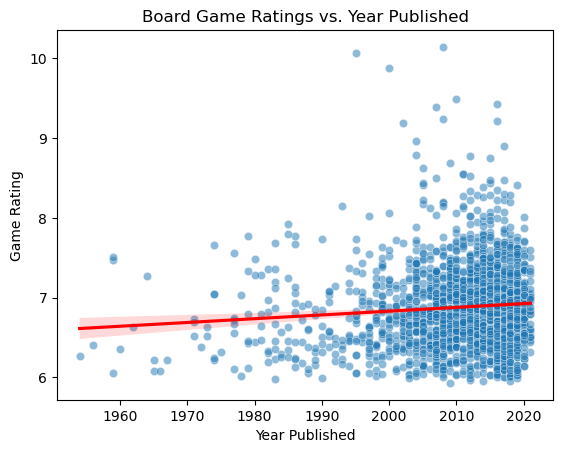

In [16]:
ax = sns.scatterplot(data=df_filtered, x='YearPublished', y='FittedValues', alpha=0.5)
sns.regplot(data=df_filtered, x='YearPublished', y='FittedValues', scatter=False, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax)

plt.title("Board Game Ratings vs. Year Published")
plt.xlabel("Year Published")
plt.ylabel("Game Rating")

plt.savefig("game_year_ratings.png")
plt.show()

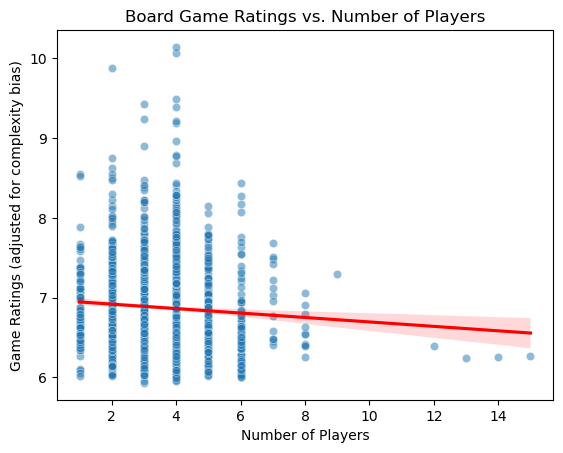

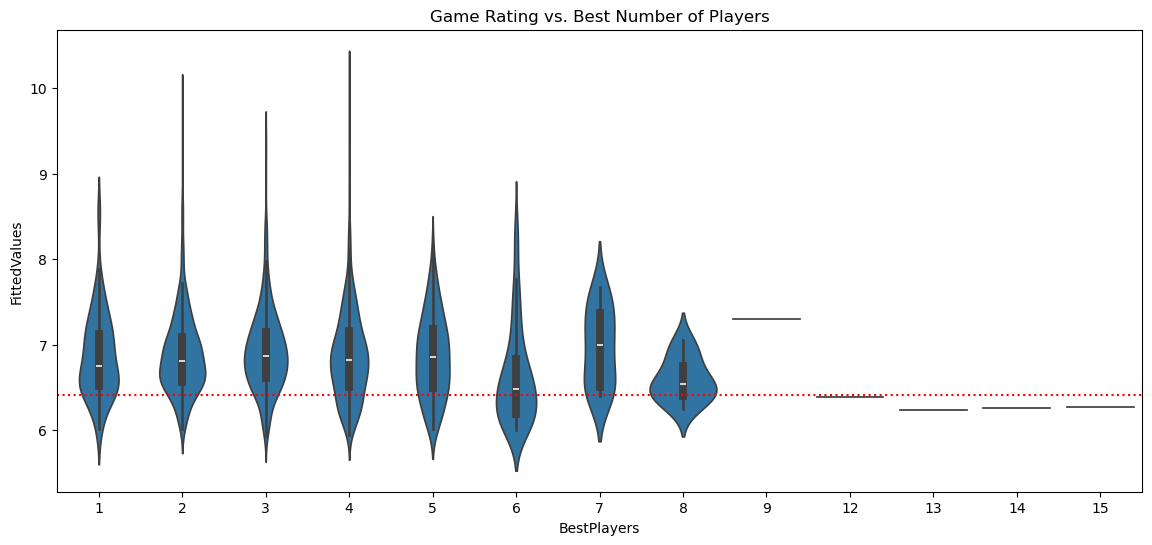

In [17]:
ax = sns.scatterplot(data=df_filtered, x='BestPlayers', y='FittedValues', alpha=0.5)
sns.regplot(data=df_filtered, x='BestPlayers', y='FittedValues', scatter=False, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ax=ax)

plt.title("Board Game Ratings vs. Number of Players")
plt.xlabel("Number of Players")
plt.ylabel("Game Ratings (adjusted for complexity bias)")

plt.savefig("number_players_ratings.png")
plt.show()


fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(x='BestPlayers', y='FittedValues', data=df_filtered)
plt.title("Game Rating vs. Best Number of Players")
plt.axhline(
        y=df['FittedValues'].median(), 
        color='red',
        linestyle='dotted'
    )
plt.savefig("violin_number_players_ratings.png")